TITLE: Macrobenthic Invertebrate Distribution and Abundance in the Thames Estuary

Context: I will be working with 3 'major' macrobenthic taxa; Annelids, Crustacea and Mollusca sampled from the Thames Estuary to briefly analyse and desrcibe patterns of abundance and diversity from 1980-2000 and 2001-2004. 

Note: The available data extends back to 1973 but the limited number of data points restricts comprehensive analysis. 

Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols  
from statsmodels.stats.anova import anova_lm  
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import geopandas as gpd


 I firstly download the zip.file containing the transitional and coastal water Biosys data from the Environemntal Agency, Ecology & Fish Data Explorer.
 

In [2]:
# the URL string
url = "https://environment.data.gov.uk/ecology/explorer/downloads/TC_BENT_OPEN_DATA_TAXA.zip"

# Read the CSV file directly from the zip file
inverts = pd.read_csv(url,dtype={14: str},  index_col="WATER_BODY") # indexed to the water body (note:free-text field but gives a rough idea of where samples were collected)
                                                                  # without dtype={14: str}, receive a DtypeWarning so force column 14 to be a string 

# Display the first few rows (making sure it has read in the right data set) instead of an integer (this means we preserve the leading characters and 0s)
print(inverts.head()) 

                          AGENCY_AREA      REPORTING_AREA SEA_AREA  \
WATER_BODY                                                           
BLACKWATER ESTUARY  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES   
BLACKWATER ESTUARY  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES   
BLACKWATER ESTUARY  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES   
BLACKWATER ESTUARY  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES   
BLACKWATER ESTUARY  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES   

                   WATERBODY_TYPE  \
WATER_BODY                          
BLACKWATER ESTUARY           WBES   
BLACKWATER ESTUARY           WBES   
BLACKWATER ESTUARY           WBES   
BLACKWATER ESTUARY           WBES   
BLACKWATER ESTUARY           WBES   

                                           WATERBODY_TYPE_DESCRIPTION  \
WATER_BODY                                                              
BLACKWATER ESTUARY  ESTUARY: Lower section of a river between fres...   
BLACKWATER ESTUARY  ESTUARY: L

Since this file contains a taxon list item key (unique ID assigned to each name in the environmental agency checklist) I then download the open Biosys taxon info zip file to combine the data columns to the actual names of the species. This seems more intuitive than having to keep referring back to the checklist.

In [3]:
# the URL string
url = "https://environment.data.gov.uk/ecology/explorer/downloads/OPEN_DATA_TAXON_INFO.zip"

# Read the CSV file directly from the zip file
info = pd.read_csv(url) 

print(info.head()) 

                   TAXON_NAME TAXON_VERSION_KEY TAXON_LIST_ITEM_KEY  \
0  Acanthococcus aciculiferus  NHMSYS0000524222    NHMSYS0000523405   
1                  Acrochaete  NHMSYS0000717510    NHMSYS0000716346   
2       Acrochaete geniculata  NBNSYS0000178801    NHMSYS0000716347   
3           Acrochaete repens  NBNSYS0000173586    NHMSYS0000716348   
4             Acrochaetiaceae  NBNSYS0000178802    NHMSYS0000716349   

             AUTHORITY  SORT_CODE TAXON_NAME_CURRENT  \
0         Lagerh. 1883          0                Yes   
1                  NaN          0                Yes   
2  (N Gardner) O'Kelly          0                Yes   
3         N Pringsheim          0                Yes   
4                  NaN          0                Yes   

         PREFERRED_TAXON_NAME PREFERRED_NAME_TVK NBN_RECOMMENDED_TVK  \
0  Acanthococcus aciculiferus   NHMSYS0000524222    NHMSYS0000599627   
1                  Acrochaete   NHMSYS0000717510    NHMSYS0000567735   
2       Acrochaete g

In [ ]:
#Inspect key columns to join on
print(inverts.columns) 
print(info.columns)       

In [4]:
# Merge datasets using a left join on "TAXON_LIST_ITEM_KEY"
merged_data = pd.merge(inverts, info, how="left", left_on="TAXON_LIST_ITEM_KEY",  
    right_on="TAXON_LIST_ITEM_KEY")

# Check the merged dataset
print(merged_data.head())  
print(merged_data.isna().sum())  

# Fill NaN values only in non-numeric columns (e.g., strings)
merged_data[merged_data.select_dtypes(include=['object']).columns] = merged_data[merged_data.select_dtypes(include=['object']).columns].fillna('Unknown')


         AGENCY_AREA      REPORTING_AREA SEA_AREA WATERBODY_TYPE  \
0  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
1  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
2  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
3  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
4  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   

                          WATERBODY_TYPE_DESCRIPTION  SITE_ID  SITE_VERSION  \
0  ESTUARY: Lower section of a river between fres...   190111             1   
1  ESTUARY: Lower section of a river between fres...   190111             1   
2  ESTUARY: Lower section of a river between fres...   190111             1   
3  ESTUARY: Lower section of a river between fres...   190111             1   
4  ESTUARY: Lower section of a river between fres...   190111             1   

  SITE_NGR_PREFIX  SITE_EASTING  SITE_NORTHING  ... PREFERRED_TAXON_NAME  \
0              TL         95000         

I am then going to subset data from Thames and extract the columns I may need for this projects analysis

In [5]:
# Define the columns to keep
columns_to_keep = ['AGENCY_AREA', 'SEA_AREA', 'WATERBODY_TYPE', 'SITE_ID', 
                  'SITE_EASTING','SITE_NORTHING', 'SITE_FULL_EASTING','SITE_FULL_NORTHING','SITE_NGR_10_FIG', 'SAMPLE_ID', 'SAMPLE_NGR_10_FIG', 'SAMPLE_DATE', 
                   'SAMPLE_METHOD', 'BENT_GRAB_DEPTH', 'NUMBER_FOUND','TAXON_LIST_ITEM_KEY', 'TAXON_NAME', 
                   'PREFERRED_TAXON_NAME', 'PARENT_TAXON_NAME', 'TAXON_TYPE', 'TAXON_GROUP_NAME', 
                   'NON_NATIVE_SP', 'PROTECTED_TAXA']

# Subset the dataframe
subset_benthic = merged_data[columns_to_keep]


# Define the rows to keep based on SEA_AREA
sea_area_to_keep = ['THAMES']

# Filter the DataFrame to include only these SEA_AREA values
subset_benthic = merged_data[merged_data['SEA_AREA'].isin(sea_area_to_keep)]

# Display the first few rows to check the filtered data
print(subset_benthic.head())

# Save the subset to a new CSV file
subset_benthic.to_csv("subset_benthic.csv", index=False)



         AGENCY_AREA      REPORTING_AREA SEA_AREA WATERBODY_TYPE  \
0  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
1  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
2  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
3  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
4  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   

                          WATERBODY_TYPE_DESCRIPTION  SITE_ID  SITE_VERSION  \
0  ESTUARY: Lower section of a river between fres...   190111             1   
1  ESTUARY: Lower section of a river between fres...   190111             1   
2  ESTUARY: Lower section of a river between fres...   190111             1   
3  ESTUARY: Lower section of a river between fres...   190111             1   
4  ESTUARY: Lower section of a river between fres...   190111             1   

  SITE_NGR_PREFIX  SITE_EASTING  SITE_NORTHING  ... PREFERRED_TAXON_NAME  \
0              TL         95000         

The edited file I use here is 'subset_benthic.csv' which can be found ....

In [6]:
# Reading the CSV file
# specify dtype for the problematic columns and force into strings
thames = pd.read_csv(
    "subset_benthic.csv",
    dtype={13: str, 19: str, 22: str, 32: str},  
    low_memory=False)

In [7]:
# Convert SAMPLE_DATE to datetime 
thames['SAMPLE_DATE'] = pd.to_datetime(thames['SAMPLE_DATE'], format='%d/%m/%Y')

# Extract the year from SAMPLE_DATE
thames['YEAR'] = thames['SAMPLE_DATE'].dt.year

# 'YEAR' column for further analysis
print(thames[['SAMPLE_DATE', 'YEAR']])

      SAMPLE_DATE  YEAR
0      2017-03-07  2017
1      2017-03-07  2017
2      2017-03-07  2017
3      2017-03-07  2017
4      2017-03-07  2017
...           ...   ...
83874  2024-06-26  2024
83875  2024-06-26  2024
83876  2024-06-26  2024
83877  2024-06-26  2024
83878  2024-06-26  2024

[83879 rows x 2 columns]


First aim: Calculating the mean macrotaxa abundance across 1980-2000 and 2001-2024 to investigate percentage change
Note: abundance count should not be based solely on the TAXON_GROUP_NAME as NUMBER_FOUND represents the total amount of individuals per taxon in each sample collected.


In [8]:
# Group by YEAR and TAXON_GROUP_NAME, summing NUMBER_FOUND
taxa_abundance = thames.groupby(['YEAR', 'TAXON_GROUP_NAME'])['NUMBER_FOUND'].sum().reset_index()

In [9]:
# Annelids
annelid_abundance = taxa_abundance[taxa_abundance['TAXON_GROUP_NAME'] == 'annelid']

annelid_period_2 = annelid_abundance[annelid_abundance['YEAR'].between(2001, 2024)]
annelid_period_3 = annelid_abundance[annelid_abundance['YEAR'].between(1980, 2000)]

# Sum abundance for each period
abundance_annelid_period_2 = annelid_period_2.groupby('TAXON_GROUP_NAME')['NUMBER_FOUND'].sum()
abundance_annelid_period_3 = annelid_period_3.groupby('TAXON_GROUP_NAME')['NUMBER_FOUND'].sum()

# Print out the summed abundance for annelids in each period 
print("Abundance of Annelids in 2001-2024:\n", abundance_annelid_period_2)
print("Abundance of Annelids in 1980-2000:\n", abundance_annelid_period_3)

# Calculate the percentage change between periods
percentage_change_2_to_3 = ((abundance_annelid_period_2 - abundance_annelid_period_3) / abundance_annelid_period_3) * 100

# Print out the percentage change for annelids
print("Percentage Change from 2001-2024 to 1980-2000 (Annelids):\n", percentage_change_2_to_3)

Abundance of Annelids in 2001-2024:
 TAXON_GROUP_NAME
annelid    1185831.0
Name: NUMBER_FOUND, dtype: float64
Abundance of Annelids in 1980-2000:
 TAXON_GROUP_NAME
annelid    13340319.0
Name: NUMBER_FOUND, dtype: float64
Percentage Change from 2001-2024 to 1980-2000 (Annelids):
 TAXON_GROUP_NAME
annelid   -91.110925
Name: NUMBER_FOUND, dtype: float64


In [10]:
# Crustacea
crustacean_abundance = taxa_abundance[taxa_abundance['TAXON_GROUP_NAME'] == 'crustacean']

crustacean_period_2 = crustacean_abundance[crustacean_abundance['YEAR'].between(2001, 2024)]
crustacean_period_3 = crustacean_abundance[crustacean_abundance['YEAR'].between(1980, 2000)]

# Sum abundance for each period
abundance_crustacean_period_2 = crustacean_period_2.groupby('TAXON_GROUP_NAME')['NUMBER_FOUND'].sum()
abundance_crustacean_period_3 = crustacean_period_3.groupby('TAXON_GROUP_NAME')['NUMBER_FOUND'].sum()

# Print out the summed abundance for annelids in each period 
print("Abundance of crustaceans in 2001-2024:\n", abundance_crustacean_period_2)
print("Abundance of crustaceans in 1980-2000:\n", abundance_crustacean_period_3)

# Calculate the percentage change between periods
percentage_change_2_to_3 = ((abundance_crustacean_period_2 - abundance_crustacean_period_3) / abundance_crustacean_period_3) * 100

# Print out the percentage change for annelids
print("Percentage Change from 2001-2024 to 1980-2000 (crustaceans):\n", percentage_change_2_to_3)

Abundance of crustaceans in 2001-2024:
 TAXON_GROUP_NAME
crustacean    165175.0
Name: NUMBER_FOUND, dtype: float64
Abundance of crustaceans in 1980-2000:
 TAXON_GROUP_NAME
crustacean    533598.0
Name: NUMBER_FOUND, dtype: float64
Percentage Change from 2001-2024 to 1980-2000 (crustaceans):
 TAXON_GROUP_NAME
crustacean   -69.045049
Name: NUMBER_FOUND, dtype: float64


In [11]:
# mollusca
mollusc_abundance = taxa_abundance[taxa_abundance['TAXON_GROUP_NAME'] == 'mollusc']

mollusc_period_2 = mollusc_abundance[mollusc_abundance['YEAR'].between(2001, 2024)]
mollusc_period_3 = mollusc_abundance[mollusc_abundance['YEAR'].between(1980, 2000)]

# Sum abundance for each period
abundance_mollusc_period_2 = mollusc_period_2.groupby('TAXON_GROUP_NAME')['NUMBER_FOUND'].sum()
abundance_mollusc_period_3 = mollusc_period_3.groupby('TAXON_GROUP_NAME')['NUMBER_FOUND'].sum()

# Print out the summed abundance for annelids in each period 
print("Abundance of molluscs in 2001-2024:\n", abundance_mollusc_period_2)
print("Abundance of molluscs in 1980-2000:\n", abundance_mollusc_period_3)

# Calculate the percentage change between periods
percentage_change_2_to_3 = ((abundance_mollusc_period_2 - abundance_mollusc_period_3) / abundance_mollusc_period_3) * 100

# Print out the percentage change for annelids
print("Percentage Change from 2001-2024 to 1980-2000 (molluscs):\n", percentage_change_2_to_3)

Abundance of molluscs in 2001-2024:
 TAXON_GROUP_NAME
mollusc    165765.0
Name: NUMBER_FOUND, dtype: float64
Abundance of molluscs in 1980-2000:
 TAXON_GROUP_NAME
mollusc    322279.0
Name: NUMBER_FOUND, dtype: float64
Percentage Change from 2001-2024 to 1980-2000 (molluscs):
 TAXON_GROUP_NAME
mollusc   -48.564753
Name: NUMBER_FOUND, dtype: float64


Second Aim: Overlaying taxa distribution onto the Thames Estuary shapefile from Geofabrik 

In [12]:
# Load the shapefile of the Thames region (replace with your actual shapefile path)
# this is found using this link https://download.geofssabrik.de/europe/united-kingdom/england-latest-free.shp.zip/gis_osm_water_a_free_1.shp
# open the zipfile to extract the shapefile needed 

import zipfile
import os

# Path to the ZIP file you downloaded
zip_file_path = r"C:\Users\User\Downloads\england-latest-free.shp.zip"  
extract_to = r"C:\Users\User\Assessment\extracted_files"  

# Make sure the extraction folder exists, otherwise create it
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the files from the ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")



Files extracted to: C:\Users\User\Assessment\extracted_files


In [13]:
# Define the path to the shapefile (I tried uploading the extracted_files to the GitHub but they were too large to upload after trying various methods including lfs install)

shapefile_path = r"C:\Users\User\Assessment\extracted_files\gis_osm_water_a_free_1.shp"

# Check if the file exists
if not os.path.exists(shapefile_path):
    raise FileNotFoundError(f"The shapefile was not found at {shapefile_path}")

# Step 2: Load the shapefile
thames_shapefile = gpd.read_file(shapefile_path)

# Display the first few rows and the structure of the shapefile
print(thames_shapefile.head())
print(thames_shapefile.info())

    osm_id  code     fclass                 name  \
0  2371851  8200      water     Christleton Pond   
1  2729539  8201  reservoir  Nanpantan Reservoir   
2  2878065  8200      water           Works Pond   
3  2907746  8201  reservoir   Cropston Reservoir   
4  2922921  8200      water         Wyndley Pool   

                                            geometry  
0  POLYGON ((-2.83603 53.18823, -2.83601 53.18827...  
1  POLYGON ((-1.25143 52.74864, -1.25139 52.74875...  
2  POLYGON ((-1.2246 52.9092, -1.22439 52.90936, ...  
3  POLYGON ((-1.2027 52.68748, -1.20259 52.68784,...  
4  POLYGON ((-1.83844 52.55748, -1.83729 52.55781...  
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 176363 entries, 0 to 176362
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osm_id    176363 non-null  object  
 1   code      176363 non-null  int32   
 2   fclass    176363 non-null  object  
 3   name      10731 non-null   ob

In [14]:
# Define the groups to filter
groups_wanted = [ 'annelid', 'mollusc','crustacean']

# Filter the DataFrame
filtered_data = thames[thames["TAXON_GROUP_NAME"].isin(groups_wanted)]

# Display the first few rows to confirm
print(filtered_data.head())

# check that the required columns exist
required_columns = ['SITE_FULL_EASTING', 'SITE_FULL_NORTHING', 'TAXON_GROUP_NAME']
if not all(col in filtered_data.columns for col in required_columns):
    raise ValueError(f"The data must contain the following columns: {', '.join(required_columns)}")



         AGENCY_AREA      REPORTING_AREA SEA_AREA WATERBODY_TYPE  \
0  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
1  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
2  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
3  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   
4  ANGLIAN - EASTERN  EAST ANGLIA - EAST   THAMES           WBES   

                          WATERBODY_TYPE_DESCRIPTION  SITE_ID  SITE_VERSION  \
0  ESTUARY: Lower section of a river between fres...   190111             1   
1  ESTUARY: Lower section of a river between fres...   190111             1   
2  ESTUARY: Lower section of a river between fres...   190111             1   
3  ESTUARY: Lower section of a river between fres...   190111             1   
4  ESTUARY: Lower section of a river between fres...   190111             1   

  SITE_NGR_PREFIX  SITE_EASTING  SITE_NORTHING  ... PREFERRED_NAME_TVK  \
0              TL         95000           

<Axes: >

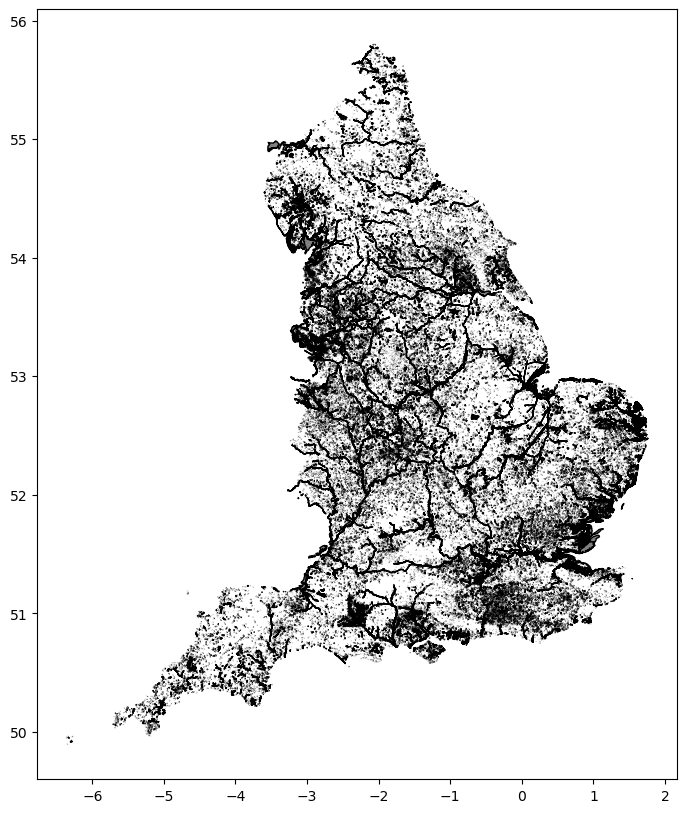

In [15]:
# GeoDataFrame using Easting and Northing
species_gdf = gpd.GeoDataFrame(
    filtered_data, 
    geometry=gpd.points_from_xy(filtered_data['SITE_FULL_EASTING'], filtered_data['SITE_FULL_NORTHING']),
    crs='EPSG:27700'  # correct coordinate reference system (CRS) for your data so here its the british national grid
)
# Plot the map of the Thames region
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Thames map
thames_shapefile.plot(ax=ax, color='gray',edgecolor='black')

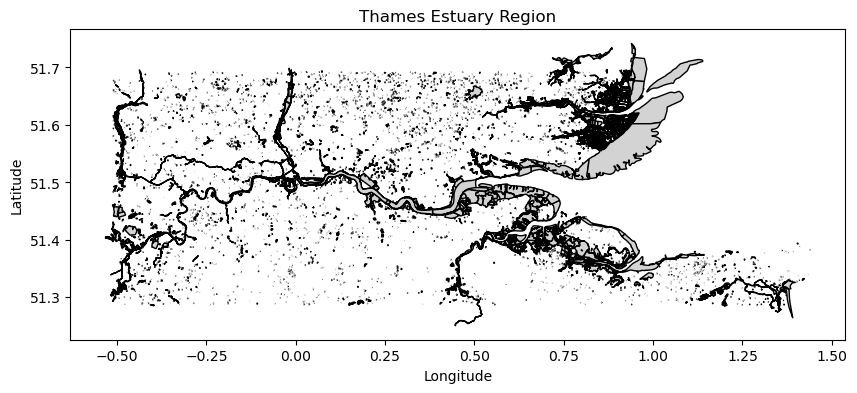

In [16]:
# Define the bounding box coordinates for the Thames Estuary
minx, miny = -0.510375, 51.286760  # Southwest corner (Longitude, Latitude)
maxx, maxy = 1.476136, 51.691874   # Northeast corner (Longitude, Latitude)

# Filter the GeoDataFrame using the bounding box
# GeoPandas uses the 'geometry' column to filter by bounding box
# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

filtered_gdf = gdf.cx[minx:maxx, miny:maxy]

# Step 5: Plot the filtered region
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered shapefile
filtered_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Add a title and labels
plt.title('Thames Estuary Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [16]:
# Step 4: Create a GeoDataFrame using Easting and Northing
species_gdf = gpd.GeoDataFrame(
    filtered_data, 
    geometry=gpd.points_from_xy(filtered_data['SITE_FULL_EASTING'], filtered_data['SITE_FULL_NORTHING']),
    crs='EPSG:27700'  # Coordinate reference system (CRS) for British National Grid
)
# Ensure filtered_gdf has the correct CRS (EPSG:27700)
# If filtered_gdf is already in EPSG:27700, this is not necessary
filtered_gdf = filtered_gdf.set_crs('EPSG:27700', allow_override=True)


# Convert species_gdf to the same CRS as filtered_gdf (EPSG:27700)
species_gdf = species_gdf.to_crs(filtered_gdf.crs)

# Check the CRS to confirm the conversion
print(filtered_gdf.crs)  # CRS of the Thames shapefile
print(species_gdf.crs)   # CRS of the species data after conversion




EPSG:27700
EPSG:27700


C:\Users\User\AppData\Local\Temp\ipykernel_29844\374805842.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Taxon Group')


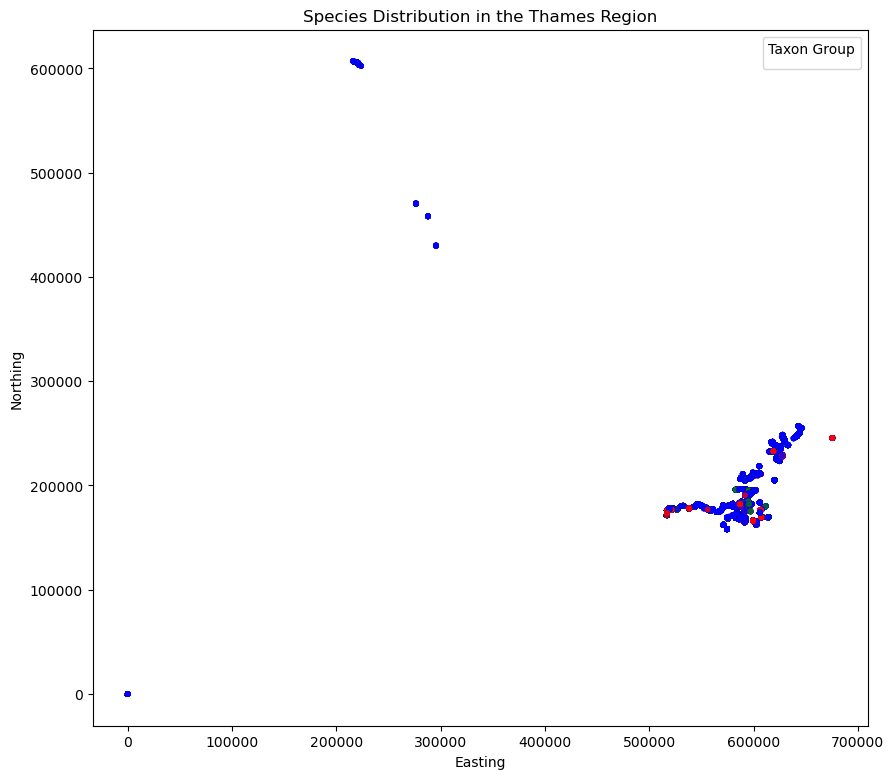

In [17]:
# Colour map for taxon groups (just to see what it looks like after correcting the CRS)
color_map = { 'annelid':'blue','crustacean': 'green', 'mollusc': 'red'}

# Map the colour for each species based on its taxon group
species_gdf['colors'] = species_gdf['TAXON_GROUP_NAME'].map(color_map).fillna('gray')

# reproject the species GeoDataFrame to match the CRS of the Thames Estuary
if species_gdf.crs != filtered_gdf.crs:
    species_gdf = species_gdf.to_crs(filtered_gdf.crs)

# Plot both the filtered Thames map and species distribution on top
fig, ax = plt.subplots(figsize=(10, 10))

# plot the filtered Thames map (background) 
filtered_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the species distribution on top of the map
species_gdf.plot(ax=ax, markersize=10, color=species_gdf['colors'], alpha=0.7, legend=True)

#Add plot labels and title
plt.title('Species Distribution in the Thames Region')
plt.xlabel('Easting')
plt.ylabel('Northing')

plt.legend(title='Taxon Group')
plt.show()

Thames CRS:  EPSG:27700
Species CRS:  EPSG:27700


C:\Users\User\AppData\Local\Temp\ipykernel_52840\2901481020.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Taxon Group')


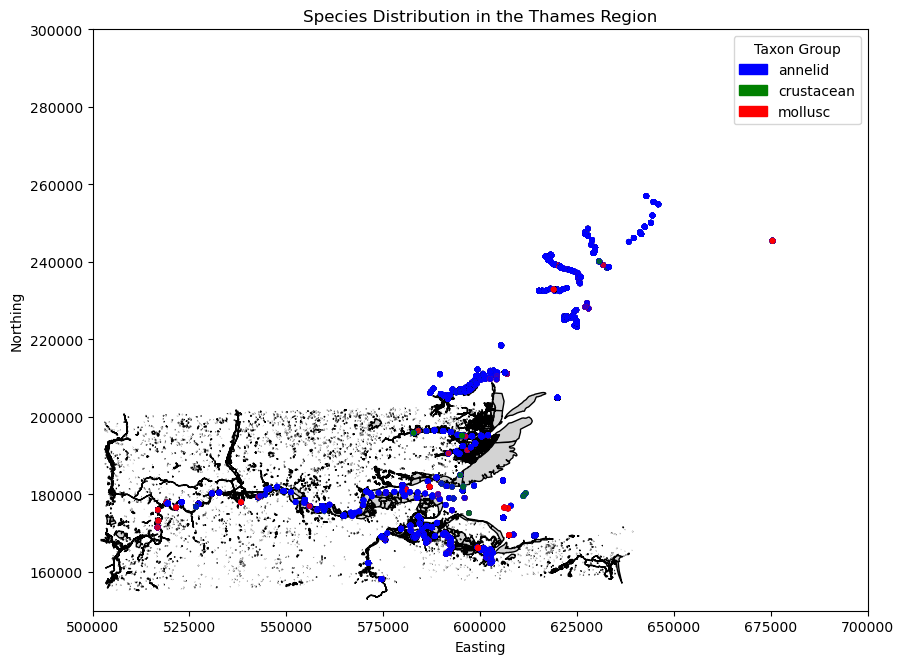

In [18]:
# Now I overlay the species distribution data over the Thames Estuary region

# Define the path to shapefile (note: I realise here that you will have to make your own file path based on where you extracted the files 
# I couldnt upload the files to the github as its over 25mb)

shapefile_path = r"C:\Users\User\Assessment\extracted_files\gis_osm_water_a_free_1.shp"

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)


# Define the bounding box coordinates for the Thames Estuary
minx, miny = -0.510375, 51.286760  # Southwest corner (Longitude, Latitude)
maxx, maxy = 1.476136, 51.691874   # Northeast corner (Longitude, Latitude)

# Filter the GeoDataFrame using the bounding box
filtered_gdf = gdf.cx[minx:maxx, miny:maxy]

# Reproject the Thames Estuary region to match the species data CRS (EPSG:27700)
filtered_gdf = filtered_gdf.to_crs(epsg=27700)

# Ensure the data contains the required columns for species distribution
required_columns = ['SITE_FULL_EASTING', 'SITE_FULL_NORTHING', 'TAXON_GROUP_NAME']
if not all(col in filtered_data.columns for col in required_columns):
    raise ValueError(f"The data must contain the following columns: {', '.join(required_columns)}")

# Create a GeoDataFrame for species distribution using Easting and Northing
species_gdf = gpd.GeoDataFrame(
    filtered_data, 
    geometry=gpd.points_from_xy(filtered_data['SITE_FULL_EASTING'], filtered_data['SITE_FULL_NORTHING']),
    crs='EPSG:27700'  # Coordinate reference system for British National Grid
)

# Color map for taxon groups
color_map = { 'annelid':'blue','crustacean': 'green', 'mollusc': 'red'}

# Map the color for each species based on its taxon group
species_gdf['colors'] = species_gdf['TAXON_GROUP_NAME'].map(color_map).fillna('gray')

# Check CRS of both layers (this is critical)
print("Thames CRS: ", filtered_gdf.crs)
print("Species CRS: ", species_gdf.crs)

#  reproject the species GeoDataFrame to match the CRS of the Thames Estuary
if species_gdf.crs != filtered_gdf.crs:
    species_gdf = species_gdf.to_crs(filtered_gdf.crs)

# Plot both the filtered Thames map and species distribution on top
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered Thames map (background) - now both are in the same CRS
filtered_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the species distribution on top of the map
species_gdf.plot(ax=ax, markersize=10, color=species_gdf['colors'], alpha=0.7, legend=True)

# Add plot labels and title
plt.title('Species Distribution in the Thames Region')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.axis([500000,700000,150000, 300000])


# Show the legend for taxon groups 
plt.legend(title='Taxon Group')

# Create a legend for the taxon groups
handles = [Patch(color=color, label=taxon) for taxon, color in color_map.items()]
plt.legend(handles=handles, title='Taxon Group', loc='upper right')


# Show the plot
plt.show()



Third aim: Using a hierarchical clustering dendrogram to visualise how different sites are clustered based on their similarity in taxa abundance across different years. (2 dendograms plooted for 1980-2000 and 2001-2024)

Euclidean distance is the dissimilarity between sites based on abundance.
The length of branches indicates the dissimilarity of clusters being joined. Longer branches means that clusters (or sites) are more dissimiliar - shorter are more similar.
The height of branches at which clusters merge give an idea of how different clusters are. i.e. a low branch means more similar. 



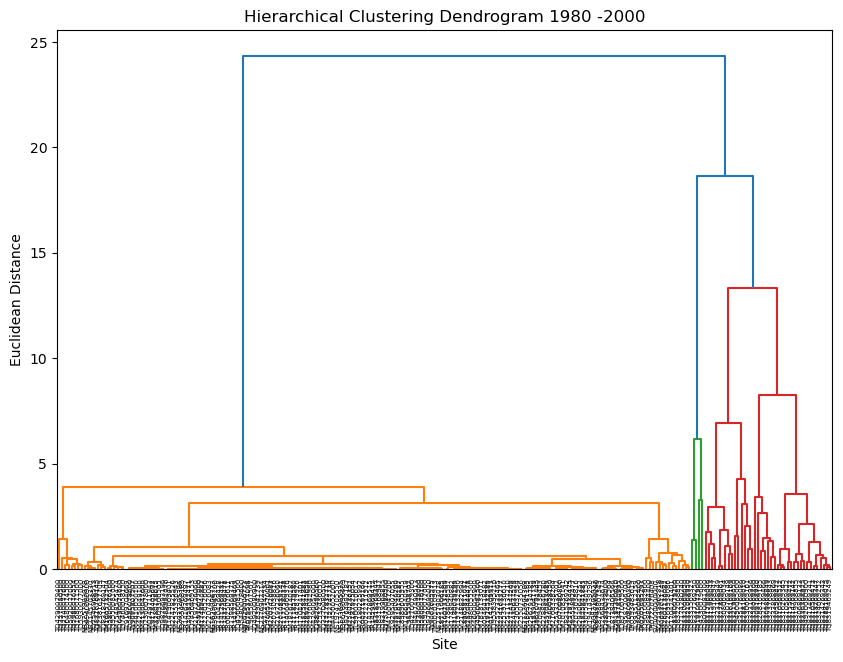

cluster
1    193
4     24
3     15
2      4
Name: count, dtype: int64


In [8]:
# Subset the data to focus on Crustacea, Mollusc, Annelids
taxa_of_interest = ['crustacean', 'annelid', 'mollusc']
subset_data = thames[thames['TAXON_GROUP_NAME'].isin(taxa_of_interest)]

# Further subset the data for years 1980 to 2000 (ensure YEAR is still a column)
subset_data = subset_data[(subset_data['YEAR'] >= 1980) & (subset_data['YEAR'] <= 2000)]


# Aggregate the data by SITE_NGR_10_FIG and TAXON_GROUP_NAME (sum NUMBER_FOUND)
# Remove YEAR from the groupby operation temporarily
aggregated_data = subset_data.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['NUMBER_FOUND'].sum().reset_index()

# Add YEAR back as a column (after aggregation)
# We can now add the YEAR column back from the subset_data
aggregated_data['YEAR'] = subset_data.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['YEAR'].first().reset_index(drop=True)

# Pivot the data so that each site has columns for each taxa abundance across years
pivot_data = aggregated_data.pivot_table(
    index=['SITE_NGR_10_FIG', 'YEAR'],  
    columns='TAXON_GROUP_NAME',  
    values='NUMBER_FOUND',
    aggfunc='sum',
    fill_value=0)

# After pivoting, reset the index to make 'YEAR' a column again
pivot_data.reset_index(inplace=True)

# Standardise the data (important for clustering)
scaler = StandardScaler()

# Ensure scaling only the taxa columns (which are the pivoted taxa abundance columns)
taxa_columns = ['crustacean', 'annelid', 'mollusc']  
pivot_data[taxa_columns] = scaler.fit_transform(pivot_data[taxa_columns])

# Perform hierarchical clustering
# I use the Ward linkage method
linked = linkage(pivot_data[taxa_columns], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    labels=pivot_data['SITE_NGR_10_FIG'].values,
    orientation='top',
    distance_sort='ascending',
    show_leaf_counts=True
)
plt.title("Hierarchical Clustering Dendrogram 1980 -2000")
plt.xlabel('Site')
plt.ylabel('Euclidean Distance')
plt.show()

#Cut the dendrogram to form clusters (adjust the number of clusters as needed)
pivot_data['cluster'] = fcluster(linked, t=4, criterion='maxclust')  # t=4 means 4 clusters

# Print the number of elements in each cluster
print(pivot_data['cluster'].value_counts())

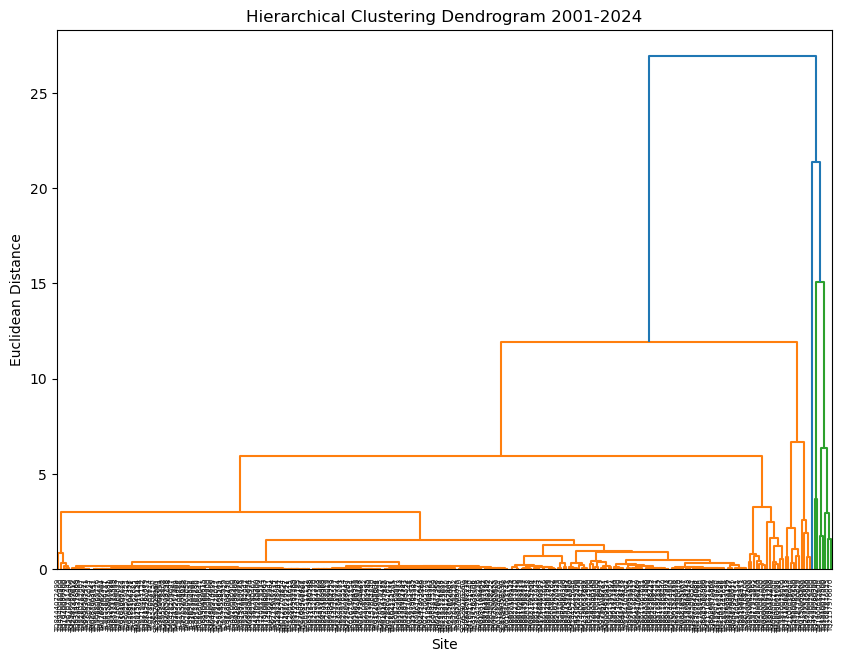

cluster
1    285
3      5
2      2
4      1
Name: count, dtype: int64


In [11]:
# Subset the data to focus on Crustacea, Mollusc, Annelids
taxa_of_interest = ['crustacean', 'annelid', 'mollusc']
subset_data = thames[thames['TAXON_GROUP_NAME'].isin(taxa_of_interest)]

# Further subset the data for years 1980 to 2000 (ensure YEAR is still a column)
subset_data = subset_data[(subset_data['YEAR'] >= 2001) & (subset_data['YEAR'] <= 2024)]

# Aggregate the data by SITE_NGR_10_FIG and TAXON_GROUP_NAME (sum NUMBER_FOUND)
# Remove YEAR from the groupby operation temporarily
aggregated_data = subset_data.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['NUMBER_FOUND'].sum().reset_index()

# Add YEAR back as a column (after aggregation)
# add the YEAR column back from the subset_data
aggregated_data['YEAR'] = subset_data.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['YEAR'].first().reset_index(drop=True)

# Pivot the data so that each site has columns for each taxa abundance across years
pivot_data = aggregated_data.pivot_table(
    index=['SITE_NGR_10_FIG', 'YEAR'],  
    columns='TAXON_GROUP_NAME',  
    values='NUMBER_FOUND',
    aggfunc='sum',
    fill_value=0)

# After pivoting, reset the index to make 'YEAR' a column again
pivot_data.reset_index(inplace=True)

# Standardise the data (important for clustering)
scaler = StandardScaler()

# Ensure scaling only the taxa columns (which are the pivoted taxa abundance columns)
taxa_columns = ['crustacean', 'annelid', 'mollusc']  
pivot_data[taxa_columns] = scaler.fit_transform(pivot_data[taxa_columns])

# Perform hierarchical clustering
##I use the Ward linkage method
linked = linkage(pivot_data[taxa_columns], method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    labels=pivot_data['SITE_NGR_10_FIG'].values,
    orientation='top',
    distance_sort='ascending',
    show_leaf_counts=True)

plt.title("Hierarchical Clustering Dendrogram 2001-2024")
plt.xlabel('Site')
plt.ylabel('Euclidean Distance')
plt.show()

# Cut the dendrogram to form clusters (adjust the number of clusters as needed)
pivot_data['cluster'] = fcluster(linked, t=4, criterion='maxclust')  # t=4 means 4 clusters

# Print the number of elements in each cluster
print(pivot_data['cluster'].value_counts())

OPTIONAL: To ease analysis of the dendograms, I have also created summary CSVs for the plots used (1980-2000 and 2001-2024) as I am aware there are so many sites sampled from and you cant see the figure legend clearly to see site groupings for the abundances across clusters.
This code is shown beneath.

In [13]:

# Subset the data for years 1980 to 2000
subset_data_1980_2000 = thames[(thames['YEAR'] >= 1980) & (thames['YEAR'] <= 2000)]

# Aggregate the data by SITE_NGR_10_FIG, YEAR, and TAXON_GROUP_NAME (sum NUMBER_FOUND)
aggregated_data_1980_2000 = subset_data_1980_2000.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['NUMBER_FOUND'].sum().reset_index()

# Add YEAR back as a column
aggregated_data_1980_2000['YEAR'] = subset_data_1980_2000.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['YEAR'].first().reset_index(drop=True)

# Step 4: Pivot the data for the 1980-2000 subset
pivot_data_1980_2000 = aggregated_data_1980_2000.pivot_table(
    index=['SITE_NGR_10_FIG', 'YEAR'],
    columns='TAXON_GROUP_NAME',
    values='NUMBER_FOUND',
    aggfunc='sum',
    fill_value=0)

pivot_data_1980_2000.reset_index(inplace=True)

# Standardise the data (important for clustering)
scaler = StandardScaler()
taxa_columns = ['crustacean', 'annelid', 'mollusc']
pivot_data_1980_2000[taxa_columns] = scaler.fit_transform(pivot_data_1980_2000[taxa_columns])

# Perform hierarchical clustering for the 1980-2000 subset
linked_1980_2000 = linkage(pivot_data_1980_2000[taxa_columns], method='ward')

# Cut the dendrogram to assign clusters for the 1980-2000 subset
pivot_data_1980_2000['cluster'] = fcluster(linked_1980_2000, t=4, criterion='maxclust')

# Create a summary table for the 1980-2000 subset
cluster_summary_1980_2000 = pivot_data_1980_2000[['SITE_NGR_10_FIG', 'cluster']].drop_duplicates()
cluster_summary_1980_2000 = cluster_summary_1980_2000.sort_values(by='cluster')

# Export the summary table for 1980-2000
cluster_summary_1980_2000.to_csv('cluster_summary_1980_2000.csv', index=False)

# Subset the data for years 2001 to 2024
subset_data_2001_2024 = thames[(thames['YEAR'] >= 2001) & (thames['YEAR'] <= 2024)]

# Aggregate the data by SITE_NGR_10_FIG, YEAR, and TAXON_GROUP_NAME (sum NUMBER_FOUND)
aggregated_data_2001_2024 = subset_data_2001_2024.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['NUMBER_FOUND'].sum().reset_index()

# Add YEAR back as a column
aggregated_data_2001_2024['YEAR'] = subset_data_2001_2024.groupby(['SITE_NGR_10_FIG', 'TAXON_GROUP_NAME'])['YEAR'].first().reset_index(drop=True)

# Pivot the data for the 2001-2024 subset
pivot_data_2001_2024 = aggregated_data_2001_2024.pivot_table(
    index=['SITE_NGR_10_FIG', 'YEAR'],
    columns='TAXON_GROUP_NAME',
    values='NUMBER_FOUND',
    aggfunc='sum',
    fill_value=0)

pivot_data_2001_2024.reset_index(inplace=True)

# Standardize the data (important for clustering)
pivot_data_2001_2024[taxa_columns] = scaler.fit_transform(pivot_data_2001_2024[taxa_columns])

# Perform hierarchical clustering for the 2001-2024 subset
linked_2001_2024 = linkage(pivot_data_2001_2024[taxa_columns], method='ward')

# Cut the dendrogram to assign clusters for the 2001-2024 subset
pivot_data_2001_2024['cluster'] = fcluster(linked_2001_2024, t=4, criterion='maxclust')

# Create a summary table for the 2001-2024 subset
cluster_summary_2001_2024 = pivot_data_2001_2024[['SITE_NGR_10_FIG', 'cluster']].drop_duplicates()
cluster_summary_2001_2024 = cluster_summary_2001_2024.sort_values(by='cluster')

# Export the summary table for 2001-2024
cluster_summary_2001_2024.to_csv('cluster_summary_2001_2024.csv', index=False)

#  print out the first few rows of the summary tables for both subsets
print("1980-2000 Cluster Summary:")
print(cluster_summary_1980_2000.head())
print("\n2001-2024 Cluster Summary:")
print(cluster_summary_2001_2024.head())

1980-2000 Cluster Summary:
TAXON_GROUP_NAME SITE_NGR_10_FIG  cluster
0                   NS1629006773        1
213                 TQ7174280240        1
216                 TQ7456469153        1
218                 TQ7460058150        1
221                 TQ7546968513        1

2001-2024 Cluster Summary:
TAXON_GROUP_NAME SITE_NGR_10_FIG  cluster
0                   SC7629070260        1
309                 TQ9051396367        1
308                 TQ9046069710        1
302                 TQ9010082800        1
301                 TQ8958578808        1


Bar chart for crustacean across Clusters and Years:


C:\Users\User\AppData\Local\Temp\ipykernel_27760\2989662944.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='YEAR', y=taxa, hue='cluster', data=bar_data, ci=None)


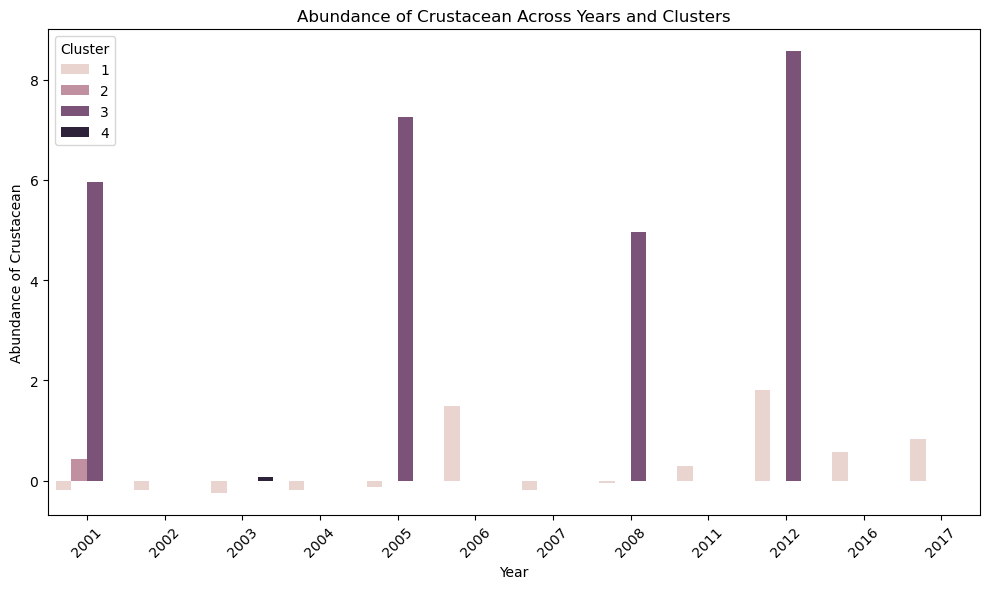

Bar chart for annelid across Clusters and Years:


C:\Users\User\AppData\Local\Temp\ipykernel_27760\2989662944.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='YEAR', y=taxa, hue='cluster', data=bar_data, ci=None)


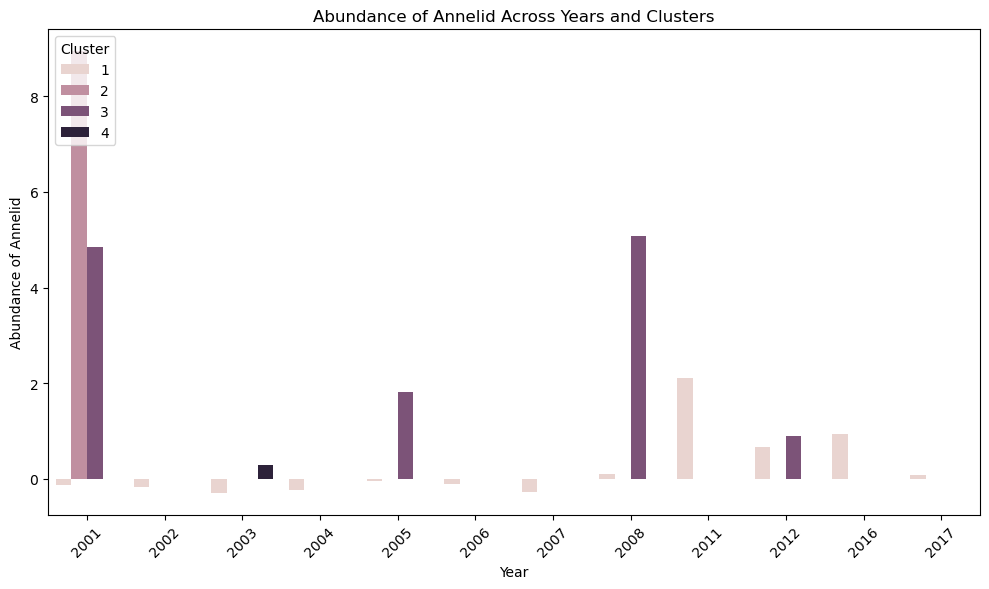

Bar chart for mollusc across Clusters and Years:


C:\Users\User\AppData\Local\Temp\ipykernel_27760\2989662944.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='YEAR', y=taxa, hue='cluster', data=bar_data, ci=None)


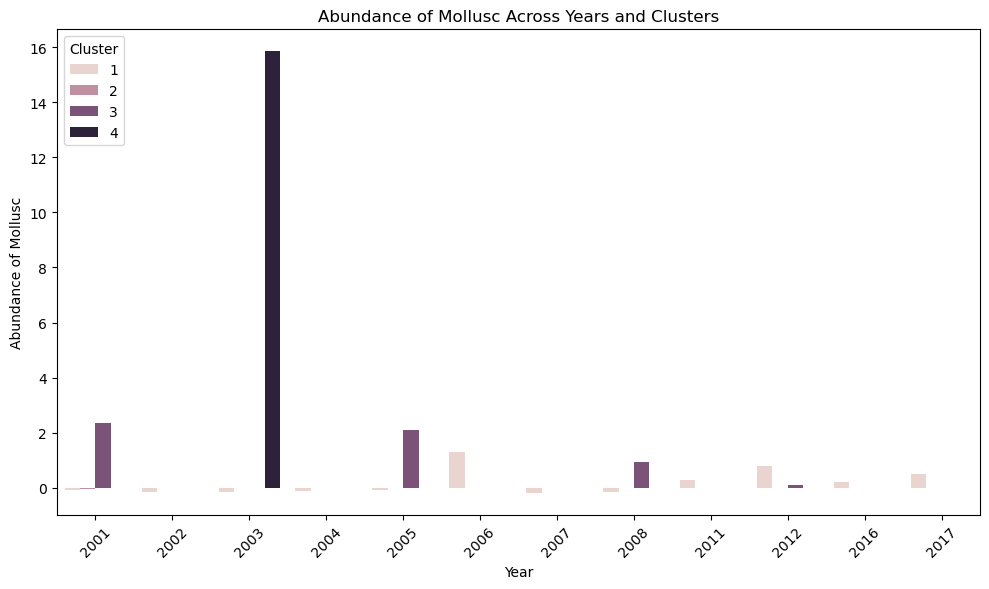

In [14]:
# (not included in report but just taking a quick visual look of abundance of taxa across a few years)

taxa_columns = ['crustacean', 'annelid', 'mollusc']  # Replace with your actual column names

# Loop through each taxa and create a bar chart
for taxa in taxa_columns:
    print(f"Bar chart for {taxa} across Clusters and Years:")
    
    # Prepare the data by aggregating the mean NUMBER_FOUND for each YEAR and cluster
    bar_data = pivot_data[['YEAR', 'cluster', taxa]].dropna()  # Remove rows with NaN values
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='YEAR', y=taxa, hue='cluster', data=bar_data, ci=None)
    
    plt.title(f"Abundance of {taxa.capitalize()} Across Years and Clusters")
    plt.xlabel('Year')
    plt.ylabel(f'Abundance of {taxa.capitalize()}')
    plt.legend(title='Cluster', loc='upper left')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Fourth aim: Running ANOVAs to see if abundance varies over years across clusters and proceeded with post-hoc testing to explore which clusters differ significantly from each other. 

In [19]:
# ANOVA for Crustaceans 
anova_crustacean = ols('crustacean ~ C(cluster)', data=pivot_data).fit()  
anova_table = sm.stats.anova_lm(anova_crustacean, typ=2)
print("ANOVA Results for Crustaceans:")
print(anova_table)

# Tukey HSD test for pairwise comparisons
tukey = pairwise_tukeyhsd(pivot_data['crustacean'], pivot_data['cluster'])
print("\nTukey's HSD Test Results for Crustaceans:")
print(tukey.summary())


ANOVA Results for Crustaceans:
                sum_sq     df           F         PR(>F)
C(cluster)  235.492079    3.0  394.480215  8.029868e-102
Residual     57.507921  289.0         NaN            NaN

Tukey's HSD Test Results for Crustaceans:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.5674 0.2791 -0.2506  1.3853  False
     1      3   6.9168    0.0  6.3968  7.4368   True
     1      4   0.1905 0.9739 -0.9642  1.3452  False
     2      3   6.3495    0.0  5.3851  7.3139   True
     2      4  -0.3769  0.901 -1.7886  1.0349  False
     3      4  -6.7263    0.0  -7.989 -5.4636   True
----------------------------------------------------


In [20]:
# ANOVA for Annelids
anova_annelid = ols('annelid ~ C(cluster)', data=pivot_data).fit()  
anova_table = sm.stats.anova_lm(anova_annelid, typ=2)
print("ANOVA Results for Annelids:")
print(anova_table)

# Tukey HSD test for pairwise comparisons
tukey = pairwise_tukeyhsd(pivot_data['annelid'], pivot_data['cluster'])
print("\nTukey's HSD Test Results for Annelids:")
print(tukey.summary())


ANOVA Results for Annelids:
                sum_sq     df           F        PR(>F)
C(cluster)  205.454507    3.0  226.078085  1.768007e-75
Residual     87.545493  289.0         NaN           NaN

Tukey's HSD Test Results for Annelids:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   9.0531    0.0   8.0439 10.0622   True
     1      3   3.0071    0.0   2.3655  3.6487   True
     1      4   0.4104  0.879  -1.0143  1.8351  False
     2      3   -6.046    0.0  -7.2359 -4.8561   True
     2      4  -8.6426    0.0 -10.3845 -6.9008   True
     3      4  -2.5967 0.0001  -4.1546 -1.0387   True
-----------------------------------------------------


In [21]:
# ANOVA for mollusca
anova_mollusc = ols('mollusc ~ C(cluster)', data=pivot_data).fit()  
anova_table = sm.stats.anova_lm(anova_mollusc, typ=2)
print("ANOVA Results for molluscs:")
print(anova_table)

# Tukey HSD test for pairwise comparisons
tukey = pairwise_tukeyhsd(pivot_data['mollusc'], pivot_data['cluster'])
print("\nTukey's HSD Test Results for Molluscs:")
print(tukey.summary())

ANOVA Results for molluscs:
                sum_sq     df           F         PR(>F)
C(cluster)  264.457858    3.0  892.578674  9.265212e-146
Residual     28.542142  289.0         NaN            NaN

Tukey's HSD Test Results for Molluscs:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0304 0.9991 -0.5459  0.6066  False
     1      3   1.5941    0.0  1.2278  1.9605   True
     1      4  15.9283    0.0 15.1148 16.7417   True
     2      3   1.5638    0.0  0.8843  2.2432   True
     2      4  15.8979    0.0 14.9033 16.8925   True
     3      4  14.3341    0.0 13.4446 15.2237   True
----------------------------------------------------
